In [1]:
import cv2
import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
from skimage.exposure import histogram
from matplotlib.pyplot import bar
from skimage.color import rgb2gray,rgb2hsv

# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math

from skimage.util import random_noise
from skimage.filters import median, gaussian
from skimage.feature import canny

# Edges
from skimage.filters import sobel_h, sobel, sobel_v,roberts, prewitt


## Read video

In [2]:
# read the first frame of the video and store it
vidcap = cv2.VideoCapture('images/LaneVideo.mp4')
success, image = vidcap.read()

In [4]:
def plot_images(img1, img2, label1="Origianl Image", label2 = "Cropped Image"):
    """Plots two images side by side."""
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Plot the first image on the first subplot
    axes[0].imshow(img1, cmap='gray')
    axes[0].set_title(label1)

    # Plot the second image on the second subplot
    axes[1].imshow(img2, cmap='gray')
    axes[1].set_title(label2)

    # Show the plot
    plt.tight_layout()
    plt.show()

## Crop Image

In [53]:
# Crop image function 
def ROI(img):
#     img = io.imread(path)
    d_row, d_col, _ = img.shape
    
    roi_maxr = d_row // 2
    roi_maxc = d_col // 2
    print(d_row, roi_maxr)
    img_arr = np.array(img)
    if d_row >= 500:
        cropped_img = img_arr[(roi_maxr + 100):d_row,:]
    elif d_row > 350:
        cropped_img = img_arr[(roi_maxr + 40):d_row,:]
    
    if d_col > 1000:
        cropped_img = img_arr[roi_maxr:d_row, 300:900]
    return cropped_img


In [54]:
cropped_img = ROI(image)

720 360


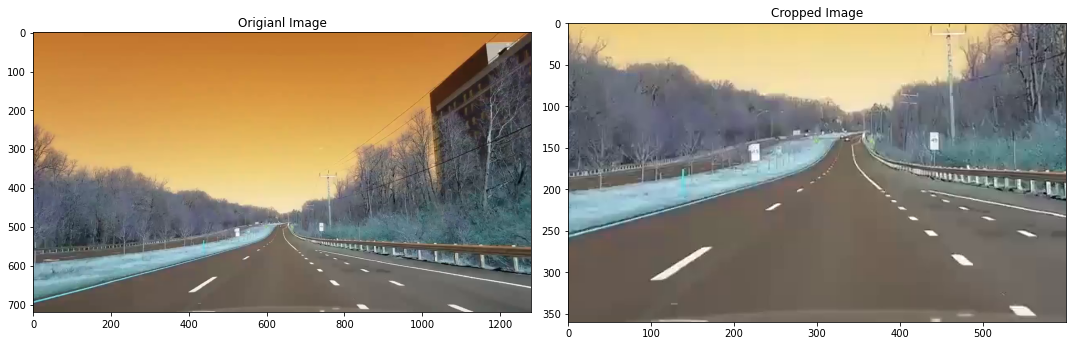

In [55]:
plot_images(image, cropped_img)

## Convert to Gray & Smoothing

In [56]:
def smooth(image):
    gray_image = rgb2gray(image)
    f_image = median(gray_image)
    return f_image

In [57]:
s_image = smooth(cropped_img)

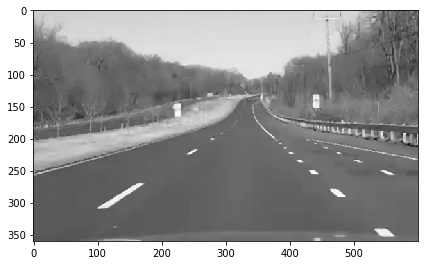

In [58]:
io.imshow(s_image)
plt.show()

## Histogram

In [59]:
def histogram_equalization(img):
    # Load image using io.imread()
#     img = io.imread(image_path)

    # Compute histogram
    hist, bins = np.histogram(img.flatten(), bins=256)

    # Compute cumulative distribution function (CDF)
    cdf = hist.cumsum()
    cdf_normalized = (cdf * hist.max()) / cdf.max()

    # Perform histogram equalization
    equalized_img = np.interp(img.flatten(), bins[:-1], cdf_normalized).reshape(img.shape)

    # ** normalize image pixel values
    min_value = np.min(equalized_img)
    max_value = np.max(equalized_img)
    # print(equalized_img, min_value, max_value)
    image_normalized = (equalized_img - min_value) / (max_value - min_value)
    
    return image_normalized

In [60]:
equalized_img = histogram_equalization(s_image)

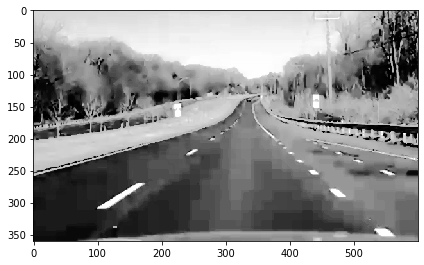

In [61]:
io.imshow(equalized_img, cmap='gray')
plt.show()

## Canny

In [62]:
def apply_filter(img, f):
    img_in_freq = fftpack.fft2(img)
    filter_in_freq = fftpack.fft2(f, img.shape)
    filtered_img_in_freq = np.multiply(img_in_freq, filter_in_freq)
    filtered_img = fftpack.ifft2(filtered_img_in_freq)
    return filtered_img

In [148]:
%time edged_image = canny(s_image, 1.1, 0.3, 0.9).astype(int).astype(float) # image with no equalization

Wall time: 23.9 ms


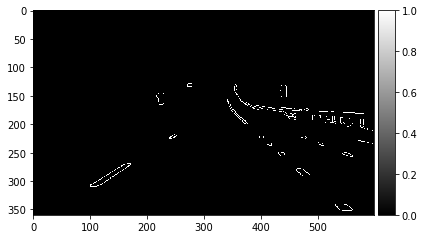

In [151]:
io.imshow(edged_image, cmap='gray')
plt.show()

In [153]:
sobel_eged_image = sobel(s_image)

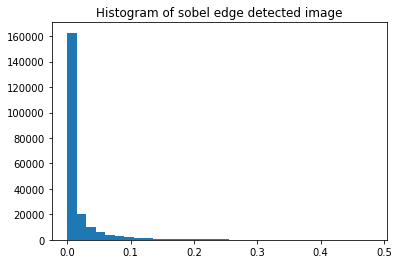

In [154]:
# get histogram of sobel edged image values
_ = plt.hist(sobel_eged_image.reshape(-1), bins=32)
plt.title("Histogram of sobel edge detected image")
plt.show()

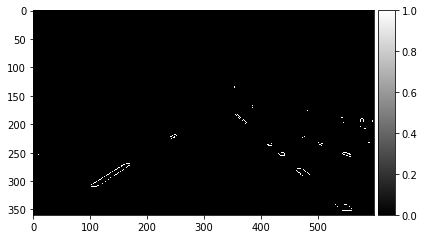

In [82]:
sobel_eged_image = np.where(sobel_eged_image > 0.3, 1, 0)
sobel_eged_image = sobel_eged_image.astype(float)
io.imshow(sobel_eged_image, cmap='gray')

## Prespective Transformation

In [146]:
def perspective_transformation(img):
    """Returns perspective transformation of an image."""
    H, W = img.shape
    
    # Define source points, points are defined as (col, row)
    d_top_left = (0, 0)
    d_top_right = (W-1, 0)
    d_bottom_left = (0, H - 1)
    d_bottom_right = (W - 1, H - 1)
    
    pts_destination = np.array([d_top_left, d_top_right, d_bottom_right, d_bottom_left], dtype=np.float32)
    
    # Define destination points
    s_top_left = (280, 180)
    s_top_right = (380, 180)
    s_bottom_left = (0, H - 1)
    s_bottom_right = (W - 1, H - 1)
    pts_source = np.array([s_top_left, s_top_right, s_bottom_right, s_bottom_left], dtype=np.float32)
    
    # Get perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(pts_source, pts_destination)
    
    # Apply perspective transformation
    result = cv2.warpPerspective(img, matrix, (W, H))
    
    return result, matrix


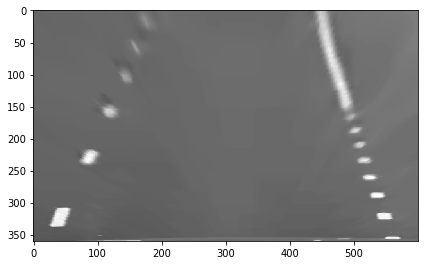

In [158]:
result, PT_matrix = perspective_transformation(s_image)
io.imshow(result, cmap='gray')